# DS projects_Kaggle Competition

# Great Energy Predictor III 

Although this competition ended 6 months ago, we are still able to submit our results and see how good the model is in the public score. 

The reason why I wanted to try to do this competition is that the competition has `datetime` data and provides other metadata. It is good chance to practice how deal with those data. 


In this notebook, I will use __fastai2__ library. 

In [1]:
from fastai2.tabular.all import *

## The goal

The goal of Great Energy Predictor III Kaggle competition is to create counterfactual models across four energy types based on historic usage rates and observed weather. It provides three years of hourly meter readings from over one thousand buildings at several different sites around the world.

## Data

Kaggle API allows us to download dataset on Jupyter notebook enviroment. 

If this is the first time for you to use Kaggle API, you need to upload your `kaggle.json` file in your working directory. 

In [2]:
#! mkdir -p ~/.kaggle/
#! mv kaggle.json ~/.kaggle/

#! mkdir %userprofile%\.kaggle
#! movie kaggle.json %userprofile%\.kaggle

By using code below, we can download dataset

In [3]:
#!kaggle competitions download -c ashrae-energy-prediction

We need to unzip the dataset

In [2]:
import os
os.getcwd()

'/home/ubuntu/fastai2_projects'

In [5]:
#p_path = Path('/Users/seoung-yeji/fastai2')

I am going to download it into 

In [6]:
#! mkdir -p {p_path}/Data/Energy

In [3]:
#path = Path('/Users/seoung-yeji/Data/Energy')
path = Path('/home/ubuntu/fastai2_projects/Data/Energy')
#! unzip -q -n {p_path}/ashrae-energy-prediction.zip -d {path}

In [4]:
path.ls()

(#11) [Path('/home/ubuntu/fastai2_projects/Data/Energy/train_cleaned_rm'),Path('/home/ubuntu/fastai2_projects/Data/Energy/models'),Path('/home/ubuntu/fastai2_projects/Data/Energy/test.csv'),Path('/home/ubuntu/fastai2_projects/Data/Energy/.ipynb_checkpoints'),Path('/home/ubuntu/fastai2_projects/Data/Energy/building_metadata.csv'),Path('/home/ubuntu/fastai2_projects/Data/Energy/test_cleaned_rm'),Path('/home/ubuntu/fastai2_projects/Data/Energy/weather_test.csv'),Path('/home/ubuntu/fastai2_projects/Data/Energy/sample_submission.csv'),Path('/home/ubuntu/fastai2_projects/Data/Energy/weather_train.csv'),Path('/home/ubuntu/fastai2_projects/Data/Energy/Exp')...]

## Data Engineering

### train.csv
- building_id - Foreign key for the building metadata.
- meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.
- timestamp - When the measurement was taken
- meter_reading - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error. UPDATE: as discussed here, the site 0 electric meter readings are in kBTU.

In [5]:
df_train = pd.read_csv(path/'train.csv', low_memory=False)
df_train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [6]:
df_train.shape

(20216100, 4)

### test.csv
The submission files use row numbers for ID codes in order to save space on the file uploads. test.csv has no feature data; it exists so you can get your predictions into the correct order.

- row_id - Row id for your submission file
- building_id - Building id code
- meter - The meter id code
- timestamp - Timestamps for the test data period

In [25]:
df_test = pd.read_csv(path/'test.csv', low_memory=False)
df_test.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01 00:00:00
1,1,1,0,2017-01-01 00:00:00
2,2,2,0,2017-01-01 00:00:00
3,3,3,0,2017-01-01 00:00:00
4,4,4,0,2017-01-01 00:00:00


In [26]:
df_test.shape

(41697600, 4)

### weather_[train/test].csv
Weather data from a meteorological station as close as possible to the site.

- site_id
- air_temperature - Degrees Celsius
- cloud_coverage - Portion of the sky covered in clouds, in oktas
- dew_temperature - Degrees Celsius
- precip_depth_1_hr - Millimeters
- sea_level_pressure - Millibar/hectopascals
- wind_direction - Compass direction (0-360)
- wind_speed - Meters per second



In [9]:
train_weather = pd.read_csv(path/'weather_train.csv', low_memory=False)
train_weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [10]:
test_weather = pd.read_csv(path/'weather_test.csv', low_memory=False)
test_weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2017-01-01 00:00:00,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,0,2017-01-01 01:00:00,17.8,2.0,12.8,0.0,1022.0,130.0,3.1
2,0,2017-01-01 02:00:00,16.1,0.0,12.8,0.0,1021.9,140.0,3.1
3,0,2017-01-01 03:00:00,17.2,0.0,13.3,0.0,1022.2,140.0,3.1
4,0,2017-01-01 04:00:00,16.7,2.0,13.3,0.0,1022.3,130.0,2.6


### building_meta.csv
- site_id - Foreign key for the weather files.
- building_id - Foreign key for training.csv
- primary_use - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
- square_feet - Gross floor area of the building
- year_built - Year building was opened
- floor_count - Number of floors of the building

In [11]:
building_meta = pd.read_csv(path/'building_metadata.csv', low_memory=False)
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


We need to merge `train.csv` and `train_weather.csv`, `building_metadata.csv`

In [12]:
def join_df(left, right, left_on, right_on=None, suffix="_y"):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on,
                     suffixes=("", suffix))

In [13]:
train = join_df(df_train, building_meta, 'building_id')
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


In [14]:
train = join_df(train, train_weather, ['site_id', 'timestamp'])
train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


Then, we need to merge `test.csv` and `test_weather.csv` and `building_meta.csv`

In [27]:
test = join_df(df_test, building_meta, 'building_id')
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN


In [28]:
test = join_df(test, test_weather, ['site_id', 'timestamp'])
test.head()

,row_id,building_id,meter,timestamp,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,0,2017-01-01 00:00:00,0,Education,7432,2008.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
1,1,1,0,2017-01-01 00:00:00,0,Education,2720,2004.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
2,2,2,0,2017-01-01 00:00:00,0,Education,5376,1991.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
3,3,3,0,2017-01-01 00:00:00,0,Education,23685,2002.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6
4,4,4,0,2017-01-01 00:00:00,0,Education,116607,1975.0,NaN,17.8,4.0,11.7,NaN,1021.4,100.0,3.6


## Handling with Datetime data

The dataset includes three years of hourly meter readings from over one thousand buildings at several different sites around the world. 

So we need to know how to deal with datetime data. 

`fastai2` library provides `add_datepart` function to create datetime data. 

In [ ]:
def make_date1(df, date_field):
    field_dtype = df[date_field].dtype
    if isinstance(field_dtype, pd.core.dtypes.dtypes.DatetimeTDZtype):
        field_dtype = np.datetime64
    if not issubdtype(field_dtype, np.datetime64):
        df[date_field] = pd.to_datetime(df[date_field], infer_datetime_format=True)
        
def ifnone1(a,b): return b if a is None else a

def add_datepart1(df, field_name, prefix=None, drop=True, time=False):
    make_date1(df, field_name)
    field = df[field_name]
    prefix = ifnone(prefix, re.sub('[Dd]ate$', '', field_name))
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofmonth', 'Is_month_end', 'Is_month_start',
           'Is_quarter_end', 'Is_quater_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[prefix+n] = getattr(field.dt, n.lower())
    df[prefix+'Elapsed'] = field.astype(np.int64) // 10 ** 9
    if drop: df.drop(field_name, axis=1, inplace=True)
    return df

In [17]:
add_datepart(train, 'timestamp', drop=True, time=True)

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampHour,timestampMinute,timestampSecond,timestampElapsed
0,0,0,0.000,0,Education,7432,2008.0,NaN,25.0,6.0,...,False,True,False,True,False,True,0,0,0,1451606400
1,1,0,0.000,0,Education,2720,2004.0,NaN,25.0,6.0,...,False,True,False,True,False,True,0,0,0,1451606400
2,2,0,0.000,0,Education,5376,1991.0,NaN,25.0,6.0,...,False,True,False,True,False,True,0,0,0,1451606400
3,3,0,0.000,0,Education,23685,2002.0,NaN,25.0,6.0,...,False,True,False,True,False,True,0,0,0,1451606400
4,4,0,0.000,0,Education,116607,1975.0,NaN,25.0,6.0,...,False,True,False,True,False,True,0,0,0,1451606400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,8.750,15,Entertainment/public assembly,19619,1914.0,NaN,1.7,NaN,...,True,False,True,False,True,False,23,0,0,1483225200
20216096,1445,0,4.825,15,Education,4298,NaN,NaN,1.7,NaN,...,True,False,True,False,True,False,23,0,0,1483225200
20216097,1446,0,0.000,15,Entertainment/public assembly,11265,1997.0,NaN,1.7,NaN,...,True,False,True,False,True,False,23,0,0,1483225200
20216098,1447,0,159.575,15,Lodging/residential,29775,2001.0,NaN,1.7,NaN,...,True,False,True,False,True,False,23,0,0,1483225200


In [29]:
add_datepart(test, 'timestamp', drop=True, time=True)

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,timestampIs_month_end,timestampIs_month_start,timestampIs_quarter_end,timestampIs_quarter_start,timestampIs_year_end,timestampIs_year_start,timestampHour,timestampMinute,timestampSecond,timestampElapsed
0,0,0,0,0,Education,7432,2008.0,NaN,17.8,4.0,...,False,True,False,True,False,True,0,0,0,1483228800
1,1,1,0,0,Education,2720,2004.0,NaN,17.8,4.0,...,False,True,False,True,False,True,0,0,0,1483228800
2,2,2,0,0,Education,5376,1991.0,NaN,17.8,4.0,...,False,True,False,True,False,True,0,0,0,1483228800
3,3,3,0,0,Education,23685,2002.0,NaN,17.8,4.0,...,False,True,False,True,False,True,0,0,0,1483228800
4,4,4,0,0,Education,116607,1975.0,NaN,17.8,4.0,...,False,True,False,True,False,True,0,0,0,1483228800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,15,Entertainment/public assembly,19619,1914.0,NaN,NaN,NaN,...,False,False,False,False,False,False,7,0,0,1525849200
41697596,41697596,1445,0,15,Education,4298,NaN,NaN,NaN,NaN,...,False,False,False,False,False,False,7,0,0,1525849200
41697597,41697597,1446,0,15,Entertainment/public assembly,11265,1997.0,NaN,NaN,NaN,...,False,False,False,False,False,False,7,0,0,1525849200
41697598,41697598,1447,0,15,Lodging/residential,29775,2001.0,NaN,NaN,NaN,...,False,False,False,False,False,False,7,0,0,1525849200


We don't need to have all datetime data. So I would like to remove some of them.

In [19]:
train.head().T

,0,1,2,3,4
building_id,0,1,2,3,4
meter,0,0,0,0,0
meter_reading,0,0,0,0,0
site_id,0,0,0,0,0
primary_use,Education,Education,Education,Education,Education
square_feet,7432,2720,5376,23685,116607
year_built,2008,2004,1991,2002,1975
floor_count,NaN,NaN,NaN,NaN,NaN
air_temperature,25,25,25,25,25
cloud_coverage,6,6,6,6,6


In [20]:
to_drop = ['timestampDayofyear', 'timestampIs_month_end', 'timestampIs_month_start', 'timestampIs_quarter_end',
          'timestampIs_quarter_start', 'timestampIs_year_end', 'timestampIs_year_start',
          'timestampMinute', 'timestampSecond', 'timestampElapsed']

In [21]:
train = train.drop(to_drop, axis=1, inplace=False)
train.head().T

,0,1,2,3,4
building_id,0,1,2,3,4
meter,0,0,0,0,0
meter_reading,0,0,0,0,0
site_id,0,0,0,0,0
primary_use,Education,Education,Education,Education,Education
square_feet,7432,2720,5376,23685,116607
year_built,2008,2004,1991,2002,1975
floor_count,NaN,NaN,NaN,NaN,NaN
air_temperature,25,25,25,25,25
cloud_coverage,6,6,6,6,6


In [32]:
#test = test.drop(to_drop, axis=1, inplace=False)
test.head().T

,0,1,2,3,4
row_id,0,1,2,3,4
building_id,0,1,2,3,4
meter,0,0,0,0,0
site_id,0,0,0,0,0
primary_use,Education,Education,Education,Education,Education
square_feet,7432,2720,5376,23685,116607
year_built,2008,2004,1991,2002,1975
floor_count,NaN,NaN,NaN,NaN,NaN
air_temperature,17.8,17.8,17.8,17.8,17.8
cloud_coverage,4,4,4,4,4


In [24]:
test

## Shrink dtypes

In [17]:
df_shrink_dtypes??

In [33]:
df_shrink??

In [34]:
n_train = df_shrink(train.copy(), int2uint=True, obj2cat=True)

In [36]:
n_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 21 columns):
 #   Column              Dtype   
---  ------              -----   
 0   building_id         uint16  
 1   meter               uint8   
 2   meter_reading       float32 
 3   site_id             uint8   
 4   primary_use         category
 5   square_feet         uint32  
 6   year_built          float32 
 7   floor_count         float32 
 8   air_temperature     float32 
 9   cloud_coverage      float32 
 10  dew_temperature     float32 
 11  precip_depth_1_hr   float32 
 12  sea_level_pressure  float32 
 13  wind_direction      float32 
 14  wind_speed          float32 
 15  timestampYear       uint16  
 16  timestampMonth      uint8   
 17  timestampWeek       uint8   
 18  timestampDay        uint8   
 19  timestampDayofweek  uint8   
 20  timestampHour       uint8   
dtypes: category(1), float32(10), uint16(2), uint32(1), uint8(7)
memory usage: 1.2 GB


In [37]:
n_test = df_shrink(test.copy(), int2uint=True, obj2cat=True)

In [38]:
n_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 21 columns):
 #   Column              Dtype   
---  ------              -----   
 0   row_id              uint32  
 1   building_id         uint16  
 2   meter               uint8   
 3   site_id             uint8   
 4   primary_use         category
 5   square_feet         uint32  
 6   year_built          float32 
 7   floor_count         float32 
 8   air_temperature     float32 
 9   cloud_coverage      float32 
 10  dew_temperature     float32 
 11  precip_depth_1_hr   float32 
 12  sea_level_pressure  float32 
 13  wind_direction      float32 
 14  wind_speed          float32 
 15  timestampYear       uint16  
 16  timestampMonth      uint8   
 17  timestampWeek       uint8   
 18  timestampDay        uint8   
 19  timestampDayofweek  uint8   
 20  timestampHour       uint8   
dtypes: category(1), float32(9), uint16(2), uint32(2), uint8(7)
memory usage: 2.5 GB


In [39]:
n_train.to_pickle(path/'train_cleaned_rm')

In [40]:
n_test.to_pickle(path/'test_cleaned_rm')

In [41]:
path.ls()

(#16) [Path('/Users/seoung-yeji/Data/Energy/sm_train'),Path('/Users/seoung-yeji/Data/Energy/weather_test.csv'),Path('/Users/seoung-yeji/Data/Energy/weather_train.csv'),Path('/Users/seoung-yeji/Data/Energy/try2'),Path('/Users/seoung-yeji/Data/Energy/train_to.pkl'),Path('/Users/seoung-yeji/Data/Energy/test.csv'),Path('/Users/seoung-yeji/Data/Energy/train_cleaned.pkl'),Path('/Users/seoung-yeji/Data/Energy/train_clean'),Path('/Users/seoung-yeji/Data/Energy/test_clean'),Path('/Users/seoung-yeji/Data/Energy/train_cleaned_rm')...]

## Handling with Categorical variables

In the data description, `meter` is categorical variable even though it has int64 dtypes. 

We need to change it to `object`. 

In [42]:
n_train['meter'] = n_train['meter'].astype(object)
n_train['meter'].unique()

array([0, 3, 1, 2], dtype=object)

Also test set

In [43]:
n_test['meter'] = n_test['meter'].astype(object)
n_test['meter'].unique()

array([0, 1, 3, 2], dtype=object)

## Metric

In this competition, we need to use `RMSLE` (Root Mean Squared Logarithmic Error) as evaludation metric. 


The RMSLE is calculated as

$$
\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$

Where:

\\(\epsilon\\) is the RMSLE value (score)
\\(n\\) is the total number of observations in the (public/private) data set,
\\(p_i\\) is your prediction of target, and
\\(a_i\\) is the actual target for \\(i\\).
\\(\log(x)\\) is the natural logarithm of \\(x\\)



In [44]:
dep_var = 'meter_reading'

In [45]:
n_train[dep_var] = np.log1p(n_train[dep_var])

In [46]:
n_train[dep_var].head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: meter_reading, dtype: float32

In [47]:
n_train[dep_var].tail()

20216095    2.277267
20216096    1.762159
20216097    0.000000
20216098    5.078761
20216099    1.348073
Name: meter_reading, dtype: float32

When I make np.log(y_value), it has `inf` value, so I would like to see if it works when it doesn't have `inf` while performing decision trees

In [28]:
train['timestamp'].min(), train['timestamp'].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2016-12-31 23:00:00'))

train has 2016 dataset

## Dealing with Missing Data

Handling with missing data is very important in DS. We might delete missing data if it doesn't have any significant effect. 

However, if there are so many missing data in dataset, then it might not be a good idea to delete all missing data. Because sometimes the fact whether it is missing data or not allows us to get important information when we interpret the data. 

So I would like to fill missing data with median (or mode if categorical variables) and make columns if they are Nan or not. 

`fastai2` has very good function, `FillMissing` when deal with missing data. However, I would like to make my own function `Missing` and I changed `FillMissing` function a little bit

Let's see which columns have missing data

In [48]:
(n_train.isnull().sum())/len(n_train)

building_id           0.000000
meter                 0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.599900
floor_count           0.826528
air_temperature       0.004781
cloud_coverage        0.436551
dew_temperature       0.004953
precip_depth_1_hr     0.185447
sea_level_pressure    0.060925
wind_direction        0.071678
wind_speed            0.007107
timestampYear         0.000000
timestampMonth        0.000000
timestampWeek         0.000000
timestampDay          0.000000
timestampDayofweek    0.000000
timestampHour         0.000000
dtype: float64

We can make a plot

In [49]:
missing = (n_train.isnull().sum() / len(n_train)).sort_values(ascending = False)*100

<Figure size 720x432 with 0 Axes>

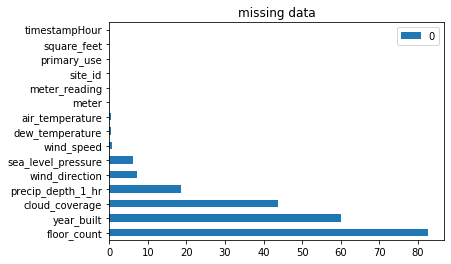

In [50]:
missing = pd.DataFrame(missing)

plt.figure(figsize = (10,6))
missing.head(15).plot(kind ='barh')
plt.title('missing data');

In [51]:
def Missing(df, max_card=20, dep_var=None):
    for label in df.columns:
        if label == dep_var: continue
        if pd.isnull(df[label]).sum():
            df[label+'_na'] = pd.isnull(df[label])
            if df[label].dtype == int or df[label].unique().shape[0] > max_card or df[label].dtype == float:
                df[label] = df[label].fillna(df[label].median())
            else: df[label] = df[label].fillna(df[label].mode())
    return df

In [52]:
Missing(n_train, max_card=1, dep_var=dep_var)

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,timestampHour,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na
0,0,0,0.000000,0,Education,7432,2008.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
1,1,0,0.000000,0,Education,2720,2004.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
2,2,0,0.000000,0,Education,5376,1991.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
3,3,0,0.000000,0,Education,23685,2002.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
4,4,0,0.000000,0,Education,116607,1975.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20216095,1444,0,2.277267,15,Entertainment/public assembly,19619,1914.0,3.0,1.7,0.0,...,23,False,True,False,True,False,False,False,False,False
20216096,1445,0,1.762159,15,Education,4298,1969.0,3.0,1.7,0.0,...,23,True,True,False,True,False,False,False,False,False
20216097,1446,0,0.000000,15,Entertainment/public assembly,11265,1997.0,3.0,1.7,0.0,...,23,False,True,False,True,False,False,False,False,False
20216098,1447,0,5.078761,15,Lodging/residential,29775,2001.0,3.0,1.7,0.0,...,23,False,True,False,True,False,False,False,False,False


Check again if there are missing data

In [53]:
(n_train.isnull().sum())/(len(n_train))

building_id              0.0
meter                    0.0
meter_reading            0.0
site_id                  0.0
primary_use              0.0
square_feet              0.0
year_built               0.0
floor_count              0.0
air_temperature          0.0
cloud_coverage           0.0
dew_temperature          0.0
precip_depth_1_hr        0.0
sea_level_pressure       0.0
wind_direction           0.0
wind_speed               0.0
timestampYear            0.0
timestampMonth           0.0
timestampWeek            0.0
timestampDay             0.0
timestampDayofweek       0.0
timestampHour            0.0
year_built_na            0.0
floor_count_na           0.0
air_temperature_na       0.0
cloud_coverage_na        0.0
dew_temperature_na       0.0
precip_depth_1_hr_na     0.0
sea_level_pressure_na    0.0
wind_direction_na        0.0
wind_speed_na            0.0
dtype: float64

In [54]:
n_train[n_train['wind_speed_na']==True][:5]

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,timestampHour,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na
722,565,0,2.110213,4,Education,15326,1954.0,2.0,16.700001,0.0,...,0,False,False,True,True,True,True,True,True,True
723,566,0,0.418052,4,Education,2010,1957.0,1.0,16.700001,0.0,...,0,False,False,True,True,True,True,True,True,True
724,569,0,5.509388,4,Education,86091,1964.0,8.0,16.700001,0.0,...,0,False,False,True,True,True,True,True,True,True
725,570,0,4.388108,4,Education,193202,1964.0,10.0,16.700001,0.0,...,0,False,False,True,True,True,True,True,True,True
726,571,0,2.890372,4,Education,47954,1980.0,3.0,16.700001,0.0,...,0,False,False,True,True,True,True,True,True,True


In [55]:
(n_test.isnull().sum())/(len(n_test))

row_id                0.000000
building_id           0.000000
meter                 0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.589916
floor_count           0.826050
air_temperature       0.005322
cloud_coverage        0.468664
dew_temperature       0.006255
precip_depth_1_hr     0.187099
sea_level_pressure    0.060359
wind_direction        0.071435
wind_speed            0.007245
timestampYear         0.000000
timestampMonth        0.000000
timestampWeek         0.000000
timestampDay          0.000000
timestampDayofweek    0.000000
timestampHour         0.000000
dtype: float64

In [56]:
Missing(n_test, max_card=1, dep_var=None)

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,timestampHour,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na
0,0,0,0,0,Education,7432,2008.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
1,1,1,0,0,Education,2720,2004.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
2,2,2,0,0,Education,5376,1991.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
3,3,3,0,0,Education,23685,2002.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
4,4,4,0,0,Education,116607,1975.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697595,41697595,1444,0,15,Entertainment/public assembly,19619,1914.0,3.0,16.700001,2.0,...,7,False,True,True,True,True,True,True,True,True
41697596,41697596,1445,0,15,Education,4298,1969.0,3.0,16.700001,2.0,...,7,True,True,True,True,True,True,True,True,True
41697597,41697597,1446,0,15,Entertainment/public assembly,11265,1997.0,3.0,16.700001,2.0,...,7,False,True,True,True,True,True,True,True,True
41697598,41697598,1447,0,15,Lodging/residential,29775,2001.0,3.0,16.700001,2.0,...,7,False,True,True,True,True,True,True,True,True


In [57]:
(n_test.isnull().sum())/(len(n_test))

row_id                   0.0
building_id              0.0
meter                    0.0
site_id                  0.0
primary_use              0.0
square_feet              0.0
year_built               0.0
floor_count              0.0
air_temperature          0.0
cloud_coverage           0.0
dew_temperature          0.0
precip_depth_1_hr        0.0
sea_level_pressure       0.0
wind_direction           0.0
wind_speed               0.0
timestampYear            0.0
timestampMonth           0.0
timestampWeek            0.0
timestampDay             0.0
timestampDayofweek       0.0
timestampHour            0.0
year_built_na            0.0
floor_count_na           0.0
air_temperature_na       0.0
cloud_coverage_na        0.0
dew_temperature_na       0.0
precip_depth_1_hr_na     0.0
sea_level_pressure_na    0.0
wind_direction_na        0.0
wind_speed_na            0.0
dtype: float64

In [58]:
n_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 30 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   building_id            uint16  
 1   meter                  object  
 2   meter_reading          float32 
 3   site_id                uint8   
 4   primary_use            category
 5   square_feet            uint32  
 6   year_built             float32 
 7   floor_count            float32 
 8   air_temperature        float32 
 9   cloud_coverage         float32 
 10  dew_temperature        float32 
 11  precip_depth_1_hr      float32 
 12  sea_level_pressure     float32 
 13  wind_direction         float32 
 14  wind_speed             float32 
 15  timestampYear          uint16  
 16  timestampMonth         uint8   
 17  timestampWeek          uint8   
 18  timestampDay           uint8   
 19  timestampDayofweek     uint8   
 20  timestampHour          uint8   
 21  year_built_na          bool  

In [59]:
n_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41697600 entries, 0 to 41697599
Data columns (total 30 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   row_id                 uint32  
 1   building_id            uint16  
 2   meter                  object  
 3   site_id                uint8   
 4   primary_use            category
 5   square_feet            uint32  
 6   year_built             float32 
 7   floor_count            float32 
 8   air_temperature        float32 
 9   cloud_coverage         float32 
 10  dew_temperature        float32 
 11  precip_depth_1_hr      float32 
 12  sea_level_pressure     float32 
 13  wind_direction         float32 
 14  wind_speed             float32 
 15  timestampYear          uint16  
 16  timestampMonth         uint8   
 17  timestampWeek          uint8   
 18  timestampDay           uint8   
 19  timestampDayofweek     uint8   
 20  timestampHour          uint8   
 21  year_built_na          bool  

In [60]:
n_train.to_pickle(path/'train_cleaned_rm')
n_test.to_pickle(path/'test_cleaned_rm')

## Handling with Categorical and Continuous variables

We need to make lists for categorical and continuous variables. `fastai2` has a wonderful function `cont_cat_spilt` to perform this. 

In [61]:
cont, cat = cont_cat_split(n_train, max_card=1, dep_var=dep_var)

In [65]:
cont = ['building_id',
 'site_id',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'timestampMonth',
 'timestampWeek',
 'timestampDay',
 'timestampDayofweek',
 'timestampHour']

In [84]:
cat = ['meter',
 'primary_use',
 'timestampYear',
 'year_built_na',
 'floor_count_na',
 'air_temperature_na',
 'cloud_coverage_na',
 'dew_temperature_na',
 'precip_depth_1_hr_na',
 'sea_level_pressure_na',
 'wind_direction_na',
 'wind_speed_na']

In [66]:
test_rowID = n_test['row_id']

In [67]:
test_rowID

0                  0
1                  1
2                  2
3                  3
4                  4
              ...   
41697595    41697595
41697596    41697596
41697597    41697597
41697598    41697598
41697599    41697599
Name: row_id, Length: 41697600, dtype: uint32

## Reducing data memory load

As we can see in `train.info()`, memory usage is over 4 GB. We need to reduce memory usage if we want to make model preformance efficient. 

In [68]:
#train.info()

In [69]:
#def reduceMS(df):
#    for label in df.columns:
#        field_dtype = df[label].dtypes
#        if field_dtype== int:
#            if df[label].max() <= np.iinfo(np.int8).max:
#                df[label] = df[label].astype(np.int8)
#            elif df[label].max() <= np.iinfo(np.int16).max:
#                df[label] = df[label].astype(np.int16)
#            elif df[label].max() <= np.iinfo(np.int32).max:
#                df[label] = df[label].astype(np.int32)
#        elif field_dtype == float:
#            if df[label].max() <= np.finfo(np.float16).max:
#                df[label] = df[label].astype(np.float16)
#            elif df[label].max() <= np.finfo(np.float32).max:
#                df[label] = df[label].astype(np.float32)
#    return df

In [70]:
#reduceMS(train)

In [71]:
#train.info()

We reduce to 1.7 GB

## Save and load data

We can save the data by using `fastai2` function `save`

In [44]:
#path

Path('/Users/seoung-yeji/fastai2/Data/Energy')

In [45]:
#path_to = Path('/Users/seoung-yeji/fastai2/Data/Energy/try2')

In [46]:
#(path_to/'train_cleaned.pkl').save(train)

If you want to load it, use the code below.

In [68]:
# train = (path/'train_cleaned.pkl').load()

## Split validation and train data

We need to set validation set because this competition doesn't give us validation dataset. It has datatime data, so we need to make validation set carefully. 

At the moment, I am not sure if this is the best choice, but I am going to take relatively recent data as a validation set. The time period for training set is 2016 year, so I would take 9 to 12 months of 2016 for validation set. 

In [72]:
n_train.shape, n_test.shape

((20216100, 30), (41697600, 30))

In [78]:
cut = (n_train.shape[0])/5
cut = int(cut)
cut

4043220

In [77]:
splits = [list(range(cut, len(n_train))), list(range(cut))]

In [83]:
n_train.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'timestampYear',
       'timestampMonth', 'timestampWeek', 'timestampDay', 'timestampDayofweek',
       'timestampHour', 'year_built_na', 'floor_count_na',
       'air_temperature_na', 'cloud_coverage_na', 'dew_temperature_na',
       'precip_depth_1_hr_na', 'sea_level_pressure_na', 'wind_direction_na',
       'wind_speed_na'],
      dtype='object')

## Using TabularPandas

In [80]:
procs = [Categorify, FillMissing]

In [85]:
to = TabularPandas(n_train, procs, cat, cont, y_names=dep_var, y_block=TransformBlock(), splits=splits)

In [86]:
len(to.train), len(to.valid)

(16172880, 4043220)

In [87]:
dls = to.dataloaders(bs=512, path=path)

In [88]:
dls.show_batch()

,meter,primary_use,timestampYear,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na,building_id,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampHour,meter_reading
0,1,Education,2016,True,False,False,True,False,False,False,False,False,1022.0,10.0,84346.0,1969.0,2.0,10.000000,0.0,6.100000,0.0,1011.299988,190.0,2.1,5.0,21.0,28.0,5.0,10.0,0.000000
1,0,Office,2016,True,True,False,True,False,False,False,False,False,1304.0,14.0,91363.0,1969.0,3.0,19.400000,0.0,17.799999,0.0,1007.700012,280.0,2.1,5.0,19.0,13.0,4.0,23.0,5.505563
2,1,Office,2016,True,True,False,False,False,False,False,False,False,1162.0,13.0,72958.0,1969.0,3.0,18.900000,4.0,8.300000,0.0,1017.900024,290.0,5.1,6.0,22.0,2.0,3.0,17.0,4.308165
3,1,Education,2016,True,True,False,True,False,False,False,False,False,1264.0,14.0,33012.0,1969.0,3.0,10.000000,0.0,7.800000,-1.0,1003.599976,40.0,5.1,5.0,18.0,6.0,4.0,12.0,5.558703
4,0,Education,2016,False,False,True,True,True,True,True,True,True,733.0,5.0,96929.0,1966.0,3.0,16.700001,0.0,8.900000,0.0,1016.000000,180.0,3.1,3.0,12.0,23.0,2.0,2.0,3.254243
5,1,Education,2016,True,True,False,True,False,False,False,False,False,786.0,6.0,257000.0,1969.0,3.0,26.100000,0.0,18.299999,0.0,1018.400024,90.0,2.1,8.0,31.0,4.0,3.0,23.0,8.032594
6,0,Manufacturing/industrial,2016,True,True,False,True,False,False,False,False,False,1172.0,13.0,63847.0,1969.0,3.0,27.799999,0.0,19.400000,-1.0,1012.700012,0.0,0.0,8.0,33.0,18.0,3.0,20.0,5.455078
7,1,Office,2016,True,True,False,False,False,False,False,False,False,238.0,2.0,45017.0,1969.0,3.0,26.100000,4.0,-2.200000,0.0,1010.200012,20.0,1.5,4.0,16.0,20.0,2.0,6.0,4.833397
8,0,Entertainment/public assembly,2016,True,True,False,False,False,False,False,False,False,1324.0,14.0,84688.0,1969.0,3.0,23.299999,0.0,8.900000,0.0,1018.599976,290.0,3.6,5.0,21.0,25.0,2.0,14.0,2.397895
9,0,Lodging/residential,2016,False,True,False,True,False,False,False,True,False,203.0,2.0,63348.0,2007.0,3.0,42.799999,0.0,11.100000,0.0,1006.400024,180.0,2.1,7.0,29.0,22.0,4.0,1.0,5.642970


In [81]:
#(path/'train_to.pkl').save(to)

# Decision Trees

In [3]:
#import os
#os.getcwd()

'/Users/seoung-yeji/fastai2'

In [4]:
#path = Path('/Users/seoung-yeji/fastai2/Data/Energy')

In [6]:
#to = (path/'train_to.pkl').load()

In [61]:
#len(to.train), len(to.valid)

(13358457, 6857643)

In [89]:
to.show(3)

,meter,primary_use,timestampYear,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na,building_id,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampHour,meter_reading
4043220,0,Education,2016,False,True,False,True,False,False,False,True,False,91,0,68094,2003.0,3.0,25.6,0.0,17.799999,0.0,1017.200012,180.0,2.1,3,11,17,3,16,0.000000
4043221,1,Education,2016,False,True,False,True,False,False,False,True,False,91,0,68094,2003.0,3.0,25.6,0.0,17.799999,0.0,1017.200012,180.0,2.1,3,11,17,3,16,8.033451
4043222,0,Office,2016,False,True,False,True,False,False,False,True,False,92,0,10779,1970.0,3.0,25.6,0.0,17.799999,0.0,1017.200012,180.0,2.1,3,11,17,3,16,0.000000


In [63]:
#to[to['meter']=='#na#'][:5]

In [90]:
to.classes

{'meter': (#5) ['#na#',0,1,2,3],
 'primary_use': (#17) ['#na#','Education','Entertainment/public assembly','Food sales and service','Healthcare','Lodging/residential','Manufacturing/industrial','Office','Other','Parking'...],
 'timestampYear': (#2) ['#na#',2016],
 'year_built_na': (#3) ['#na#',False,True],
 'floor_count_na': (#3) ['#na#',False,True],
 'air_temperature_na': (#3) ['#na#',False,True],
 'cloud_coverage_na': (#3) ['#na#',False,True],
 'dew_temperature_na': (#3) ['#na#',False,True],
 'precip_depth_1_hr_na': (#3) ['#na#',False,True],
 'sea_level_pressure_na': (#3) ['#na#',False,True],
 'wind_direction_na': (#3) ['#na#',False,True],
 'wind_speed_na': (#3) ['#na#',False,True]}

## 1. Creating the Decision Tree

In [91]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [92]:
samp_idx = np.random.permutation(len(y))[:50000]

In [93]:
from sklearn.tree import DecisionTreeRegressor

In [94]:
m = DecisionTreeRegressor(max_leaf_nodes=4).fit(xs.iloc[samp_idx], y.iloc[samp_idx])

In [69]:
from dtreeviz.trees import *

In [95]:
dep_var

'meter_reading'

We can create functions to check the RMSE of the model, since that is how the Kaggle competition was judged:

In [96]:
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [97]:
m_rmse(m, xs.iloc[samp_idx], y.iloc[samp_idx])

1.908037

Use full dataset

In [ ]:
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

## Random Forests

In [98]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
def rf(xs, y, n_estimators=40, max_samples=200_000,
      max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=1, n_estimators=n_estimators,
                                max_samples=max_samples, max_features=max_features,
                                min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [100]:
m = rf(xs, y);

In [101]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.758618, 1.017098)

### 1. Tree Variance for Prediction Confidence

In [102]:
preds = np.stack([t.predict(valid_xs)] for t in m.estimators_)

/Users/seoung-yeji/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if (await self.run_code(code, result,  async_=asy)):


In [103]:
preds.shape

(40, 1, 4043220)

In [104]:
preds_std = preds.std(0)

In [105]:
preds_std[:5]

array([[2.16758727, 1.81778459, 1.32615343, ..., 0.20415642, 0.6920142 ,
        0.20415642]])

### 2. Feature Importance

In [106]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols': df.columns, 'imp': m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [110]:
fi = rf_feat_importance(m, xs)
fi[:30]

,cols,imp
14,square_feet,0.315392
12,building_id,0.152271
0,meter,0.138559
25,timestampWeek,0.051101
17,air_temperature,0.045540
1,primary_use,0.045082
13,site_id,0.041046
15,year_built,0.040046
19,dew_temperature,0.032011
16,floor_count,0.029151


In [108]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

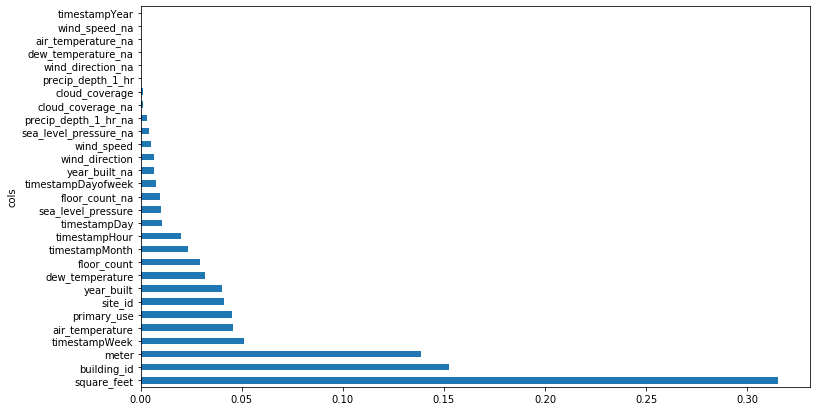

In [109]:
plot_fi(fi[:30])

### 3. Removing Low-Importance Variable

In [111]:
to_keep1 = fi[fi.imp>0.0003].cols
len(to_keep1)

24

In [112]:
xs_imp1 = xs[to_keep1]
valid_imp1 = valid_xs[to_keep1]

In [113]:
m = rf(xs_imp1, y)

In [114]:
m_rmse(m, xs_imp1, y), m_rmse(m, valid_imp1, valid_y)

(0.754134, 1.014721)

original = (0.758618, 1.017098)

In [117]:
len(xs.columns), len(xs_imp1.columns)

(29, 24)

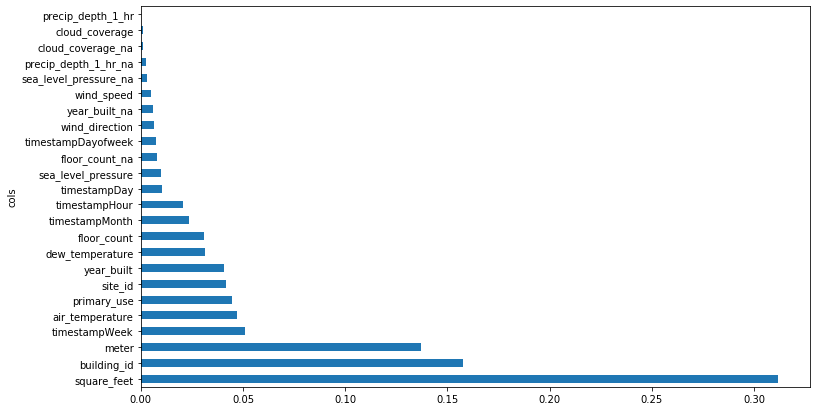

In [118]:
plot_fi(rf_feat_importance(m, xs_imp1))

In [120]:
fi1 = rf_feat_importance(m, xs_imp1)

In [121]:
fi1[:20]

,cols,imp
0,square_feet,0.311853
1,building_id,0.157525
2,meter,0.137068
3,timestampWeek,0.051155
4,air_temperature,0.047334
5,primary_use,0.044701
6,site_id,0.041502
7,year_built,0.040498
8,dew_temperature,0.031482
9,floor_count,0.031028


In [122]:
to_keep2 = fi1[fi1.imp>0.005].cols
len(to_keep2)

19

In [123]:
xs_imp2 = xs[to_keep2]
valid_imp2 = valid_xs[to_keep2]

In [124]:
m = rf(xs_imp2, y)

In [125]:
m_rmse(m, xs_imp2, y), m_rmse(m, valid_imp2, valid_y)

(0.754978, 1.012303)

In [126]:
len(xs.columns), len(xs_imp1.columns), len(xs_imp2.columns)

(29, 24, 19)

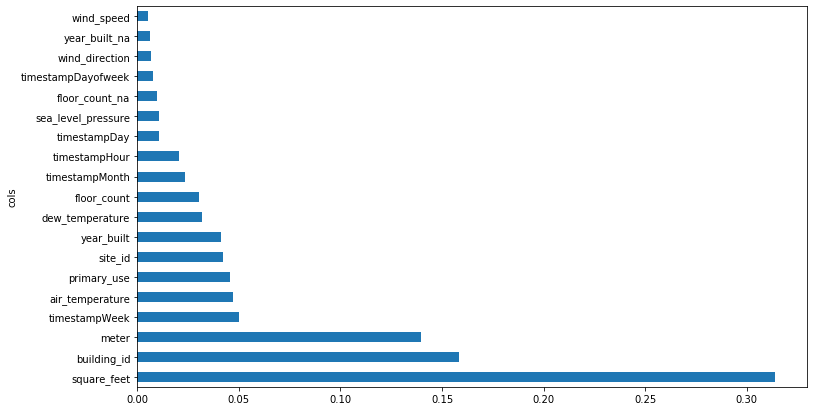

In [127]:
plot_fi(rf_feat_importance(m, xs_imp2));

In [128]:
fi2 = rf_feat_importance(m, xs_imp2)

In [129]:
fi2[:20]

,cols,imp
0,square_feet,0.313888
1,building_id,0.158236
2,meter,0.139652
3,timestampWeek,0.050148
4,air_temperature,0.047112
5,primary_use,0.045633
6,site_id,0.042016
7,year_built,0.041318
8,dew_temperature,0.031669
9,floor_count,0.030194


In [130]:
to_keep3 = fi2[fi2.imp>0.007].cols
len(to_keep3)

16

In [131]:
xs_imp3 = xs[to_keep3]
valid_imp3 = valid_xs[to_keep3]

In [132]:
m = rf(xs_imp3, y)

In [133]:
m_rmse(m, xs_imp3, y), m_rmse(m, valid_imp3, valid_y)

(0.74745, 1.005992)

In [134]:
len(xs.columns), len(xs_imp1.columns), len(xs_imp2.columns), len(xs_imp3.columns)

(29, 24, 19, 16)

(0.758618, 1.017098), (0.754134, 1.014721), (0.754978, 1.012303), (0.74745, 1.005992)

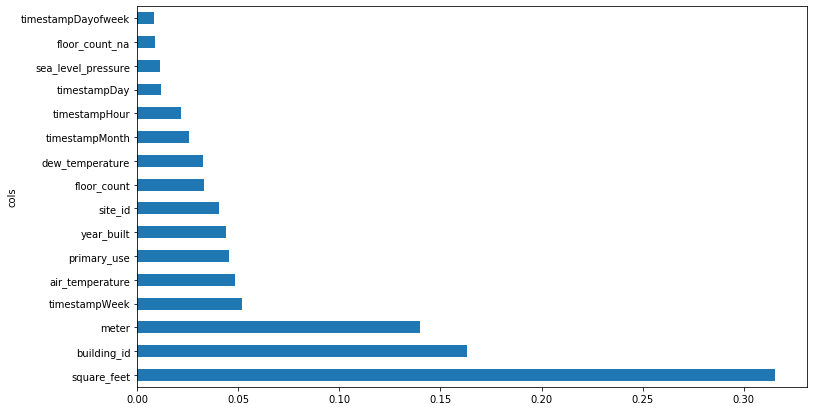

In [135]:
plot_fi(rf_feat_importance(m, xs_imp3))

In [136]:
fi3 = rf_feat_importance(m, xs_imp3)

In [137]:
fi3[:20]

,cols,imp
0,square_feet,0.315544
1,building_id,0.163092
2,meter,0.139701
3,timestampWeek,0.051594
4,air_temperature,0.048262
5,primary_use,0.045150
7,year_built,0.043652
6,site_id,0.040301
9,floor_count,0.033049
8,dew_temperature,0.032629


In [138]:
to_keep4 = fi3[fi3.imp> 0.01].cols
len(to_keep4)

14

In [139]:
xs_imp4 = xs[to_keep4]
valid_imp4 = valid_xs[to_keep4]

In [140]:
m = rf(xs_imp4, y)

In [141]:
m_rmse(m, xs_imp4, y), m_rmse(m, valid_imp4, valid_y)

(0.753912, 1.012421)

In [143]:
len(xs.columns), len(xs_imp1.columns), len(xs_imp2.columns), len(xs_imp3.columns), len(xs_imp4.columns)

(29, 24, 19, 16, 14)

(0.758618, 1.017098), (0.754134, 1.014721), (0.754978, 1.012303), (0.74745, 1.005992), (0.753912, 1.012421), 

In [144]:
fi4 = rf_feat_importance(m, xs_imp4)

In [145]:
fi4[:20]

,cols,imp
0,square_feet,0.319581
1,building_id,0.163158
2,meter,0.141202
3,timestampWeek,0.051801
4,air_temperature,0.049914
5,primary_use,0.047194
6,year_built,0.044259
7,site_id,0.042846
8,floor_count,0.034438
9,dew_temperature,0.033449


In [146]:
to_keep5 = fi4[fi4.imp>0.02].cols
len(to_keep5)

12

In [147]:
xs_imp5 = xs[to_keep5]
valid_imp5 = valid_xs[to_keep5]

In [148]:
m = rf(xs_imp5, y)

In [149]:
m_rmse(m, xs_imp5, y), m_rmse(m, valid_imp5, valid_y)

(0.763086, 1.000708)

In [150]:
len(xs.columns), len(xs_imp1.columns), len(xs_imp2.columns), len(xs_imp3.columns), len(xs_imp4.columns), len(xs_imp5.columns)

(29, 24, 19, 16, 14, 12)

In [151]:
fi5 = rf_feat_importance(m, xs_imp5)

In [152]:
fi5[:20]

,cols,imp
0,square_feet,0.319797
1,building_id,0.166281
2,meter,0.139078
3,timestampWeek,0.057609
4,air_temperature,0.052651
7,site_id,0.048468
5,primary_use,0.047866
6,year_built,0.043981
8,floor_count,0.037455
9,dew_temperature,0.036260


In [153]:
to_keep6 = fi4[fi4.imp>0.03].cols
len(to_keep6)

10

In [154]:
xs_imp6 = xs[to_keep6]
valid_imp6 = valid_xs[to_keep6]

In [155]:
m = rf(xs_imp6, y)

In [156]:
m_rmse(m, xs_imp6, y), m_rmse(m, valid_imp6, valid_y)

(0.816324, 1.030352)

(0.758618, 1.017098), (0.754134, 1.014721), (0.754978, 1.012303), (0.74745, 1.005992), (0.753912, 1.012421), (0.763086, 1.000708)

In [159]:
xs_final = xs[to_keep5]
valid_final = valid_xs[to_keep5]
len(xs_final.columns)

12

In [161]:
xs_final.columns

Index(['square_feet', 'building_id', 'meter', 'timestampWeek',
       'air_temperature', 'primary_use', 'year_built', 'site_id',
       'floor_count', 'dew_temperature', 'timestampMonth', 'timestampHour'],
      dtype='object')

These are final columns that I chose to use. 

### 4. Removing Redundant Features

In [162]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

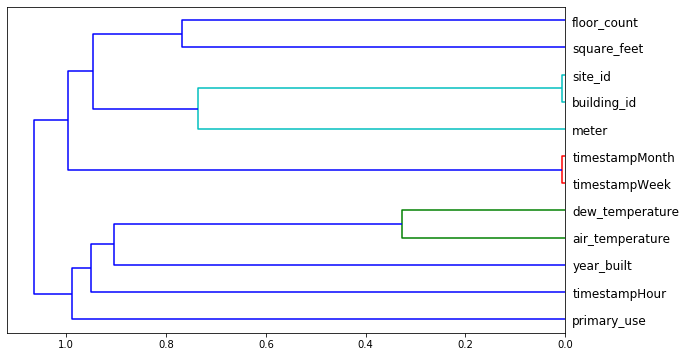

In [163]:
cluster_columns(xs_final)

In [164]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15, 
                             max_samples=50000, max_features=0.5, n_jobs=1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [165]:
d_tables=['timestampMonth', 'timestampWeek']

In [166]:
get_oob(xs_final)

0.7417471573824745

In [167]:
{c: get_oob(xs_imp1.drop(c, axis=1)) for c in d_tables}

{'timestampMonth': 0.7323249637690612, 'timestampWeek': 0.7293848811026836}

In [168]:
drop_cls = ['timestampWeek']

In [169]:
xs_final = xs_final.drop(drop_cls, axis=1)
valid_final = valid_final.drop(drop_cls, axis=1)

In [171]:
len(xs_final.columns), len(xs.columns)

(11, 29)

In [118]:
np.log1p??

In [119]:
np.log??

In [172]:
xs_final.columns

Index(['square_feet', 'building_id', 'meter', 'air_temperature', 'primary_use',
       'year_built', 'site_id', 'floor_count', 'dew_temperature',
       'timestampMonth', 'timestampHour'],
      dtype='object')

In [173]:
m = rf(xs_final, y)

In [174]:
m_rmse(m, xs_final, y), m_rmse(m, valid_final, valid_y)

(0.821836, 0.996117)

original = (0.758618, 1.017098)

xs_imp5 = (0.763086, 1.000708)

## Partial Dependence

As we've seen, the two most important predictors are `square_feet` and `meter`. We'd like to understand the relationship between these predictors and `meter_reading`. 

__Partial dependence plots__ try to answer the question: if a row varied on nothing other than the feature in question, how would it impact the dependent variable?

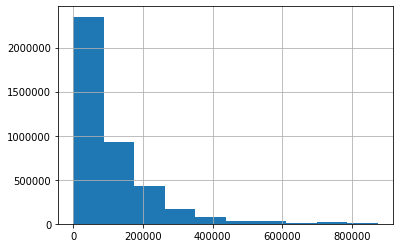

In [175]:
ax = valid_final['square_feet'].hist()

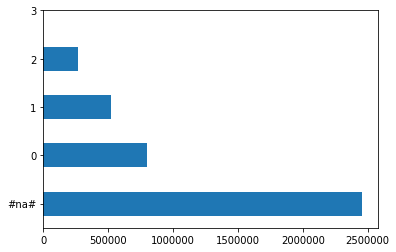

In [177]:
p = valid_final['meter'].value_counts(sort=False).plot.barh()
c = to.classes['meter']
plt.yticks(range(len(c)),c);

The largest group is #na# (missing values). 

In [178]:
from sklearn.inspection import plot_partial_dependence

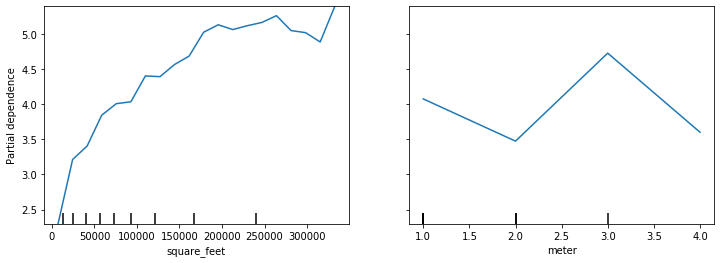

In [180]:
fig, ax = plt.subplots(figsize=(12,4))

plot_partial_dependence(m, valid_final, ['square_feet', 'meter'],
                       grid_resolution=20, ax=ax);

In `square_feet` graph, as square_feet increases, meter_reading would increase. But in over 300,000 square_feet, meter_reading slightly dropped and increased again. We might need to find out why or what factors have an effect on meter_reading there. 

meter - The meter id code. Read as {0: electricity, 1: chilledwater, 2: steam, 3: hotwater}. Not every building has all meter types.

In [181]:
xs_final.meter.unique()

array([1, 2, 4, 3], dtype=int8)

In [182]:
to.classes['meter']

(#5) ['#na#',0,1,2,3]

Indeed, the second highest important column is `building_id`. 

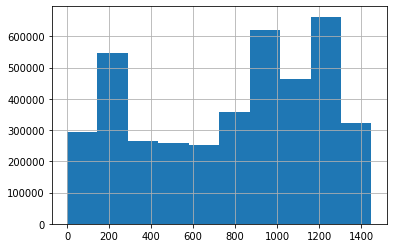

In [183]:
ax = valid_final['building_id'].hist()

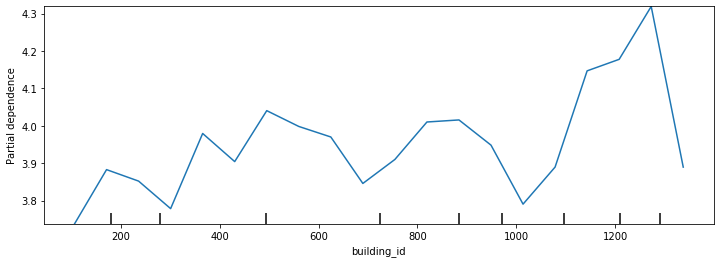

In [185]:
fig, ax = plt.subplots(figsize=(12,4))

plot_partial_dependence(m, valid_final, ['building_id'],
                       grid_resolution=20, ax=ax);

## Tree Interpreter

In [187]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [188]:
from treeinterpreter import treeinterpreter

In [189]:
from waterfall_chart import plot as waterfall

To answer the question: __for predicting with a particular row of data, what were the most important factors, and how did they influence that predictions??__

We need to use the `treeinterpreter` library. 

In [190]:
row = valid_final.iloc[:5]

In [191]:
prediction, bias, contributions = treeinterpreter.predict(m, row.values)

- __prediction__: the prediction that the random forest makes. 

- __bias__: the prediction based on taking the mean of the dependent variable (i.e. the model that is the root of every tree). 

- __contributions__: it tells us the total dchange in prediction due to each of the independent variables. Therefore, the sum of `contributions` plus `bias` must equal the `prediction`. 

In [192]:
prediction[0], bias[0], contributions[0].sum()

(array([0.40686261]), 4.191256649027954, -3.7843940407342624)

`waterfall` plot shows how the positive and negative contributions from all the independent variables sum up to create the final prediction, which is the righthand column labeled "`net`" here:

<module 'matplotlib.pyplot' from '/Users/seoung-yeji/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/matplotlib/pyplot.py'>

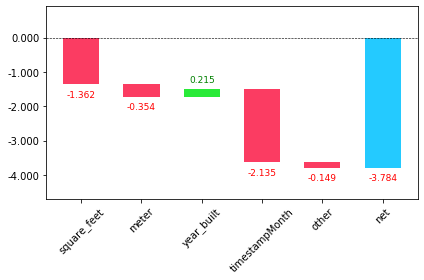

In [193]:
waterfall(valid_final.columns, contributions[0], threshold=0.08,
         rotation_value=45, formatting='{:,.3f}')

<module 'matplotlib.pyplot' from '/Users/seoung-yeji/opt/anaconda3/envs/fastai2/lib/python3.7/site-packages/matplotlib/pyplot.py'>

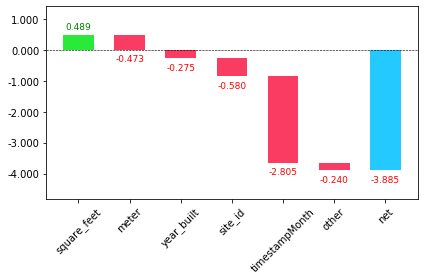

In [204]:
waterfall(valid_final.columns, contributions[4], threshold=0.08,
         rotation_value=45, formatting='{:,.3f}')

In [205]:
row

,square_feet,building_id,meter,air_temperature,primary_use,year_built,site_id,floor_count,dew_temperature,timestampMonth,timestampHour
0,7432,0,1,25.0,1,2008.0,0,3.0,20.0,1,0
1,2720,1,1,25.0,1,2004.0,0,3.0,20.0,1,0
2,5376,2,1,25.0,1,1991.0,0,3.0,20.0,1,0
3,23685,3,1,25.0,1,2002.0,0,3.0,20.0,1,0
4,116607,4,1,25.0,1,1975.0,0,3.0,20.0,1,0


## Finding Out-of-Domain Data

In [206]:
df_dom = pd.concat([xs_final, valid_final])

In [207]:
is_valid = np.array([0]*len(xs_final) + [1]*len(valid_final))

In [209]:
m = rf(df_dom, is_valid)
rf_feat_importance(m, df_dom)[:20]

,cols,imp
9,timestampMonth,0.803958
8,dew_temperature,0.074756
3,air_temperature,0.069898
1,building_id,0.017771
10,timestampHour,0.014089
6,site_id,0.008940
0,square_feet,0.004588
5,year_built,0.001876
4,primary_use,0.001594
7,floor_count,0.001489


This shows that there are three columns that differ significantly between the training and validation sets: 

   - `timestampMonth`, `dew_temperature`, `air_temperature`. 

Let's get a baseline of the original random forest models' RMSE, then see what the effect is of removing each of these columns in turn: 

In [210]:
m = rf(xs_final, y)
print('original', m_rmse(m, valid_final, valid_y))

original 0.993879


In [218]:
for c in ('timestampMonth', 'dew_temperature', 'air_temperature'):
    m = rf(xs_final.drop(c, axis=1), y)
    print(c, m_rmse(m, valid_final.drop(c, axis=1), valid_y))

timestampMonth 1.311243
dew_temperature 0.991377
air_temperature 1.050195


In [212]:
m = rf(xs_final.drop('air_temperature', axis=1), y)
print('air_temperature', m_rmse(m, valid_final.drop('air_temperature', axis=1), valid_y))

air_temperature 1.051005


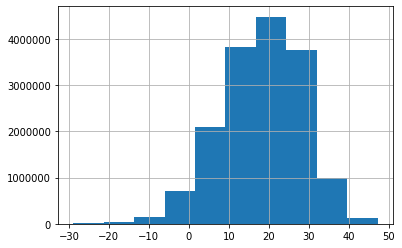

In [213]:
xs_final['air_temperature'].hist()

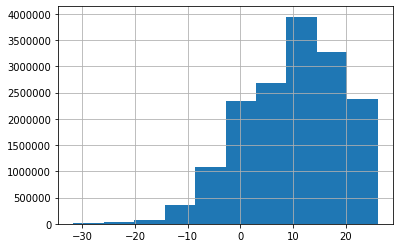

In [214]:
xs_final['dew_temperature'].hist()

In [215]:
xs_final.columns

Index(['square_feet', 'building_id', 'meter', 'air_temperature', 'primary_use',
       'year_built', 'site_id', 'floor_count', 'dew_temperature',
       'timestampMonth', 'timestampHour'],
      dtype='object')

In [216]:
xs.columns

Index(['meter', 'primary_use', 'timestampYear', 'year_built_na',
       'floor_count_na', 'air_temperature_na', 'cloud_coverage_na',
       'dew_temperature_na', 'precip_depth_1_hr_na', 'sea_level_pressure_na',
       'wind_direction_na', 'wind_speed_na', 'building_id', 'site_id',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'timestampMonth',
       'timestampWeek', 'timestampDay', 'timestampDayofweek', 'timestampHour'],
      dtype='object')

In [217]:
len(xs.columns), len(xs_final.columns)

(29, 11)

## Neural Network (Deep Learning)

From here, I am going to use a neural network model. 

1. Use all columns (factors) I cleaned before (29 features). 

    - `train_cleaned_rm`, `test_cleaned_rm`
    - Going back to "split validation and train set"

2. Use some columns I chosed before (11 features). 

    - Going back to xs_final.columns

In [5]:
train = (path/'train_cleaned_rm').load()

In [6]:
train.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,timestampHour,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na
0,0,0,0.0,0,Education,7432,2008.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
1,1,0,0.0,0,Education,2720,2004.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
2,2,0,0.0,0,Education,5376,1991.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
3,3,0,0.0,0,Education,23685,2002.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False
4,4,0,0.0,0,Education,116607,1975.0,3.0,25.0,6.0,...,0,False,True,False,False,False,True,False,False,False


In [7]:
test = (path/'test_cleaned_rm').load()

In [8]:
test.head()

,row_id,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,...,timestampHour,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na
0,0,0,0,0,Education,7432,2008.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
1,1,1,0,0,Education,2720,2004.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
2,2,2,0,0,Education,5376,1991.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
3,3,3,0,0,Education,23685,2002.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False
4,4,4,0,0,Education,116607,1975.0,3.0,17.799999,4.0,...,0,False,True,False,False,False,True,False,False,False


In [9]:
test_rowID = test['row_id']
test_rowID.head()

0    0
1    1
2    2
3    3
4    4
Name: row_id, dtype: uint32

In [10]:
train.shape, test.shape

((20216100, 30), (41697600, 30))

In [11]:
train.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'timestampYear',
       'timestampMonth', 'timestampWeek', 'timestampDay', 'timestampDayofweek',
       'timestampHour', 'year_built_na', 'floor_count_na',
       'air_temperature_na', 'cloud_coverage_na', 'dew_temperature_na',
       'precip_depth_1_hr_na', 'sea_level_pressure_na', 'wind_direction_na',
       'wind_speed_na'],
      dtype='object')

In [12]:
len(train.columns), len(test.columns)

(30, 30)

In [13]:
test.columns

Index(['row_id', 'building_id', 'meter', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr',
       'sea_level_pressure', 'wind_direction', 'wind_speed', 'timestampYear',
       'timestampMonth', 'timestampWeek', 'timestampDay', 'timestampDayofweek',
       'timestampHour', 'year_built_na', 'floor_count_na',
       'air_temperature_na', 'cloud_coverage_na', 'dew_temperature_na',
       'precip_depth_1_hr_na', 'sea_level_pressure_na', 'wind_direction_na',
       'wind_speed_na'],
      dtype='object')

In [14]:
cont = ['building_id',
 'site_id',
 'square_feet',
 'year_built',
 'floor_count',
 'air_temperature',
 'cloud_coverage',
 'dew_temperature',
 'precip_depth_1_hr',
 'sea_level_pressure',
 'wind_direction',
 'wind_speed',
 'timestampMonth',
 'timestampWeek',
 'timestampDay',
 'timestampDayofweek',
 'timestampHour']

In [15]:
cat = ['meter',
 'primary_use',
 'timestampYear',
 'year_built_na',
 'floor_count_na',
 'air_temperature_na',
 'cloud_coverage_na',
 'dew_temperature_na',
 'precip_depth_1_hr_na',
 'sea_level_pressure_na',
 'wind_direction_na',
 'wind_speed_na']

## Split validation and train data

In [16]:
cut = (train.shape[0])/5
cut = int(cut)
cut

4043220

In [17]:
splits = [list(range(cut, len(train))), list(range(cut))]

In [18]:
dep_var = 'meter_reading'

In [19]:
train[dep_var].tail()

20216095    2.277267
20216096    1.762159
20216097    0.000000
20216098    5.078761
20216099    1.348073
Name: meter_reading, dtype: float32

## Using TabularPandas

In [20]:
procs = [Categorify, FillMissing, Normalize]

In [21]:
to = TabularPandas(train, procs, cat, cont, y_names=dep_var, y_block=TransformBlock(), splits=splits)

In [22]:
len(to.train), len(to.valid)

(16172880, 4043220)

In [23]:
dls = to.dataloaders(bs=512, path=path)

In [24]:
dls.show_batch()

,meter,primary_use,timestampYear,year_built_na,floor_count_na,air_temperature_na,cloud_coverage_na,dew_temperature_na,precip_depth_1_hr_na,sea_level_pressure_na,wind_direction_na,wind_speed_na,building_id,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,timestampMonth,timestampWeek,timestampDay,timestampDayofweek,timestampHour,meter_reading
0,0,Entertainment/public assembly,2016,False,False,False,True,False,True,True,False,False,744.000002,5.0,48641.999305,1918.999997,5.0,7.000000,-2.216050e-08,3.000000,1.974135e-08,1016.000000,240.000001,6.200000e+00,3.0,13.000000,29.0,1.000000e+00,2.100000e+01,3.091043
1,1,Healthcare,2016,False,True,False,True,False,False,False,False,False,207.999984,2.0,36904.000187,1933.999997,3.0,38.300000,-2.216050e-08,16.100000,1.974135e-08,1004.700012,289.999996,1.500000e+00,7.0,30.000000,29.0,4.000000e+00,8.000000e+00,5.198652
2,0,Office,2016,False,True,False,True,False,True,False,False,False,1366.000010,15.0,87977.000179,1947.000001,3.0,-4.399999,-2.216050e-08,-11.700001,1.974135e-08,1009.900024,229.999999,7.200000e+00,12.0,49.999999,15.0,3.000000e+00,2.000000e+00,3.784758
3,1,Lodging/residential,2016,True,True,False,True,False,False,False,False,False,878.000000,9.0,41241.001744,1969.000001,3.0,6.100000,-2.216050e-08,-5.599999,1.974135e-08,1033.699951,-0.000006,-7.020390e-09,12.0,49.000000,10.0,5.000000e+00,-1.651430e-07,3.313528
4,0,Education,2016,False,True,False,False,False,False,False,False,False,213.000002,2.0,49661.998436,1963.999999,3.0,31.100000,4.000000e+00,13.900000,1.974135e-08,1007.900025,130.000001,6.700000e+00,8.0,34.000000,22.0,-9.820664e-08,5.000000e+00,5.257027
5,1,Lodging/residential,2016,True,True,False,True,False,False,False,False,False,1280.000019,14.0,79899.999543,1969.000001,3.0,22.799999,-2.216050e-08,15.600000,1.974135e-08,1010.799988,229.999999,2.600000e+00,6.0,24.000000,16.0,3.000000e+00,2.000000e+00,0.000000
6,0,Lodging/residential,2016,False,True,False,False,False,True,False,False,False,1399.000019,15.0,166814.000842,1929.000000,3.0,2.800000,-2.216050e-08,-4.400001,1.974135e-08,1015.500000,80.000003,2.600000e+00,11.0,46.000000,15.0,1.000000e+00,4.000000e+00,4.390738
7,0,Public services,2016,True,True,False,True,False,False,False,False,False,403.999998,3.0,5782.997390,1969.000001,3.0,14.400000,-2.216050e-08,10.000000,1.974135e-08,1028.699951,120.000001,3.600000e+00,10.0,41.000000,12.0,2.000000e+00,2.000000e+00,5.229021
8,1,Office,2016,True,True,False,False,False,False,False,False,False,1166.999995,13.0,52747.998690,1969.000001,3.0,23.299999,2.000000e+00,14.400000,1.974135e-08,1016.500000,100.000002,3.600000e+00,6.0,25.000000,23.0,3.000000e+00,2.300000e+01,2.978545
9,0,Public services,2016,True,True,False,True,False,False,False,False,False,496.999999,3.0,7732.002620,1969.000001,3.0,7.200000,-2.216050e-08,-10.000001,1.974135e-08,1018.200012,310.000001,6.700000e+00,12.0,49.000000,8.0,3.000000e+00,2.200000e+01,2.770086


In [25]:
np.min(train['meter_reading']), np.max(train['meter_reading'])

(0.0, 16.902212142944336)

In [26]:
max_log_y = np.log(1.2) + np.max(train['meter_reading'])
y_range = (-0.5, max_log_y)

In [27]:
y_range

(-0.5, 17.08453369973829)

In [28]:
dls.c=1

In [29]:
learn = tabular_learner(dls, layers=[1000,500], loss_func=F.mse_loss, 
                       config=tabular_config(ps=[0.001,0.01], embed_p=0.04, y_range=y_range))

In [30]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(17, 8)
    (2): Embedding(2, 2)
    (3): Embedding(3, 3)
    (4): Embedding(3, 3)
    (5): Embedding(3, 3)
    (6): Embedding(3, 3)
    (7): Embedding(3, 3)
    (8): Embedding(3, 3)
    (9): Embedding(3, 3)
    (10): Embedding(3, 3)
    (11): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(17, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.001, inplace=False)
      (2): Linear(in_features=58, out_features=1000, bias=False)
      (3): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.01, inplace=False)
      (2): Linear(in_features=1000, out_features=500, bias=False)
      (3): ReLU(i

In [31]:
len(dls.train_ds.cont_names)

17

SuggestedLRs(lr_min=0.002290867641568184, lr_steep=0.00019054606673307717)

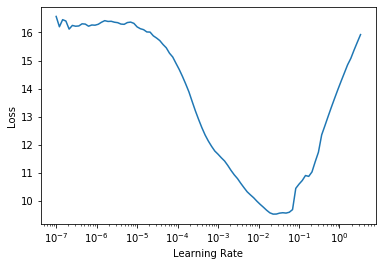

In [32]:
learn.lr_find()

In [47]:
#lr = 3e-3
lr2 = 1e-3 # better results than 3e-3

In [48]:
learn.fit_one_cycle(3, lr2, wd=0.2)

epoch,train_loss,valid_loss,time
0,1.325459,1.632329,09:00
1,1.082542,1.624211,09:02
2,0.853693,1.392996,08:56


In [38]:
# lr=3e-3
preds, targs = learn.get_preds()

In [36]:
def r_mse(preds, targs): return round(math.sqrt(((preds-targs)**2).mean()), 6)

In [40]:
r_mse(preds, targs)

1.210349

In [42]:
learn.save('nn-lr-3e3')

In [49]:
# lr=1e-3
preds, targs = learn.get_preds()

In [50]:
r_mse(preds, targs)

1.180249

In [51]:
learn.save('nn-lr-1e3')

lr's 1e-3 is better than 1e-2 and 3e-3

In [53]:
lr = 1e-2

In [54]:
learn.fit_one_cycle(3, lr, wd=0.2)

KeyboardInterrupt: 

In [ ]:
learn.recorder.plot_loss(skip_start=1000)

In [33]:
lr=1e-3

In [34]:
learn.fit_one_cycle(6, lr, wd=0.2)

epoch,train_loss,valid_loss,time
0,1.365295,2.208021,08:56
1,1.273005,1.672233,08:58
2,1.203432,1.641022,08:52
3,1.065518,1.575300,08:55
4,0.927913,1.605416,08:56
5,0.830921,1.563293,08:51


In [35]:
learn.save('nn-lr-1e3')

In [37]:
#lr=1e-3
preds, targs = learn.get_preds()

In [38]:
r_mse(preds, targs)

1.250313

## Test set

In [39]:
tt = pd.read_csv(path/'sample_submission.csv')
tt.head()

,row_id,meter_reading
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


In [40]:
test_to = to.new(test)

In [41]:
test_to.process()

In [42]:
test_dls = test_to.dataloaders(bs=512, path=path, shuffle_train=False)

In [43]:
learn.metrics=[]

In [44]:
tst_preds, _ = learn.get_preds(dl=test_dls.train)

In [46]:
np.exp(tst_preds.numpy()).T.shape

(1, 41697600)

In [47]:
test['meter_reading'] = np.exp(tst_preds.numpy()).T[0]

In [48]:
test[['row_id', 'meter_reading']] = test[['row_id', 'meter_reading']].astype('int')

In [49]:
test[['row_id', 'meter_reading']].tail()

,row_id,meter_reading
41697595,41697595,7
41697596,41697596,4
41697597,41697597,2
41697598,41697598,237
41697599,41697599,4


In [50]:
test[['row_id', 'meter_reading']].to_csv(path/'energy_submission1.csv', index=False)

In [51]:
! kaggle competitions submit competitive-data-science-predict-future-sales -f {path/'energy_submission1.csv'} -m "My submission"

100%|████████████████████████████████████████| 480M/480M [00:07<00:00, 65.0MB/s]
Successfully submitted to Predict Future Sales